# Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os, pathlib, glob, math
import warnings

from sklearn.metrics import mean_squared_error, mean_absolute_error,  r2_score, mean_absolute_percentage_error

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
from datetime import datetime

from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

sns.set_context("paper")

# Data Loading

In [2]:
data_dir = "PB/"
data_dir = pathlib.Path(data_dir)
folder = list(data_dir.glob('*'))
print('Folder Structure:')
for f in folder:
    print(f)

Folder Structure:
PB\Precio_Bolsa_Nacional_($kwh)_2018.xlsx
PB\Precio_Bolsa_Nacional_($kwh)_2019.xlsx
PB\Precio_Bolsa_Nacional_($kwh)_2020.xlsx
PB\Precio_Bolsa_Nacional_($kwh)_2021.xlsx
PB\Precio_Bolsa_Nacional_($kwh)_2022.xlsx


In [3]:
datosPB = pd.DataFrame()
for f in sorted(glob.glob(str(data_dir)+"/*.xlsx")):
  df = pd.read_excel(f, engine='openpyxl', header=2)
  datosPB = pd.concat([datosPB,df], axis=0, sort=False, ignore_index=True)
datosPB = datosPB.dropna(axis=1)
datosPB = datosPB.drop(labels=['Fecha'],axis=1)
datosPB = pd.DataFrame({"Electricity_Bid_Price":datosPB.stack().reset_index(drop=True)})
rng = pd.date_range(start = '2018-01-01 00:00', end ='2022-12-31 23:00', freq='h')
datosPB = datosPB.set_index(rng)
print(datosPB.shape)
datosPB.head(5)

(43824, 1)


,Electricity_Bid_Price
2018-01-01 00:00:00,123.167294
2018-01-01 01:00:00,123.167294
2018-01-01 02:00:00,123.167294
2018-01-01 03:00:00,123.167294
2018-01-01 04:00:00,123.167294


# Data Pre-processing

## Train-test Splitting

In [4]:
fin_train = '2021-12-31 23:00:00'
inicio_prueba = '2022-01-01 00:00:00'

datosPB_train = datosPB.loc[: fin_train, :]
datosPB_test = datosPB.loc[inicio_prueba:, :]

train_size = datosPB_train.shape[0]
test_size = datosPB_test.shape[0]

print(f"Fechas train      : {datosPB_train.index.min()} --- {datosPB_train.index.max()}")
print(f"Fechas test       : {datosPB_test.index.min()} --- {datosPB_test.index.max()}")

Fechas train      : 2018-01-01 00:00:00 --- 2021-12-31 23:00:00
Fechas test       : 2022-01-01 00:00:00 --- 2022-12-31 23:00:00


# Model Building

In [5]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
  total_len = train_len + horizon
  end_idx = train_len

  if method == 'SARIMA':
    pred_SARIMA = []
    for i in range(train_len, total_len, window):
      model = SARIMAX(df[:i], order=(2,0,0))
      res = model.fit(disp=False)
      predictions = res.get_prediction(0, i + window - 1)
      oos_pred = predictions.predicted_mean.iloc[-window:]
      pred_SARIMA.extend(oos_pred)
    return pred_SARIMA

  elif method == 'HW':
    pred_HW = []
    for i in range(train_len, total_len, window):
      model = ExponentialSmoothing(df[:i], initialization_method='estimated', seasonal_periods=24)
      res = model.fit()
      predictions = res.predict(0, i + window - 1)
      oos_pred = predictions.iloc[-window:]
      pred_HW.extend(oos_pred)
    return pred_HW

In [6]:
TRAIN_LEN = datosPB['2021-01-01 00:00:00':'2021-12-31 23:00:00'].shape[0]
HORIZON = datosPB_test['2022-01-01 00:00:00':'2022-12-31 23:00:00'].shape[0]
WINDOW = 8
pred_SARIMAX = rolling_forecast(datosPB['2021-01-01 00:00:00':'2022-12-31 23:00:00'], TRAIN_LEN, HORIZON, WINDOW, 'SARIMA')
pred_HW = rolling_forecast(datosPB['2021-01-01 00:00:00':'2022-12-31 23:00:00'], TRAIN_LEN, HORIZON, WINDOW, 'HW')

In [7]:
real_data = datosPB_test['2022-01-01 00:00:00':'2022-12-31 23:00:00']
print("MSE:", mean_squared_error(real_data, pred_HW))
print("RMSE:", math.sqrt(mean_squared_error(real_data, pred_HW)))
print("MAE:", mean_absolute_error(real_data, pred_HW))
print("MAPE:", mean_absolute_percentage_error(real_data, pred_HW)*100)
print("R2:", r2_score(real_data, pred_HW))

MSE: 3008.4669492040816
RMSE: 54.849493609367826
MAE: 25.031846007379084
MAPE: 11.398303321898311
R2: 0.8128856993094953


In [8]:
real_data = datosPB_test['2022-01-01 00:00:00':'2022-12-31 23:00:00']
print("MSE:", mean_squared_error(real_data, pred_SARIMAX))
print("RMSE:", math.sqrt(mean_squared_error(real_data, pred_SARIMAX)))
print("MAE:", mean_absolute_error(real_data, pred_SARIMAX))
print("MAPE:", mean_absolute_percentage_error(real_data, pred_SARIMAX)*100)
print("R2:", r2_score(real_data, pred_SARIMAX))

MSE: 2983.305108205948
RMSE: 54.619640315603945
MAE: 25.725237811396365
MAPE: 11.514806418642213
R2: 0.8144506625821338


In [ ]:
np.savetxt("Forecasting_Results/datos_Pred_CM.csv", np.column_stack((pred_HW,pred_SARIMAX)), delimiter=",")

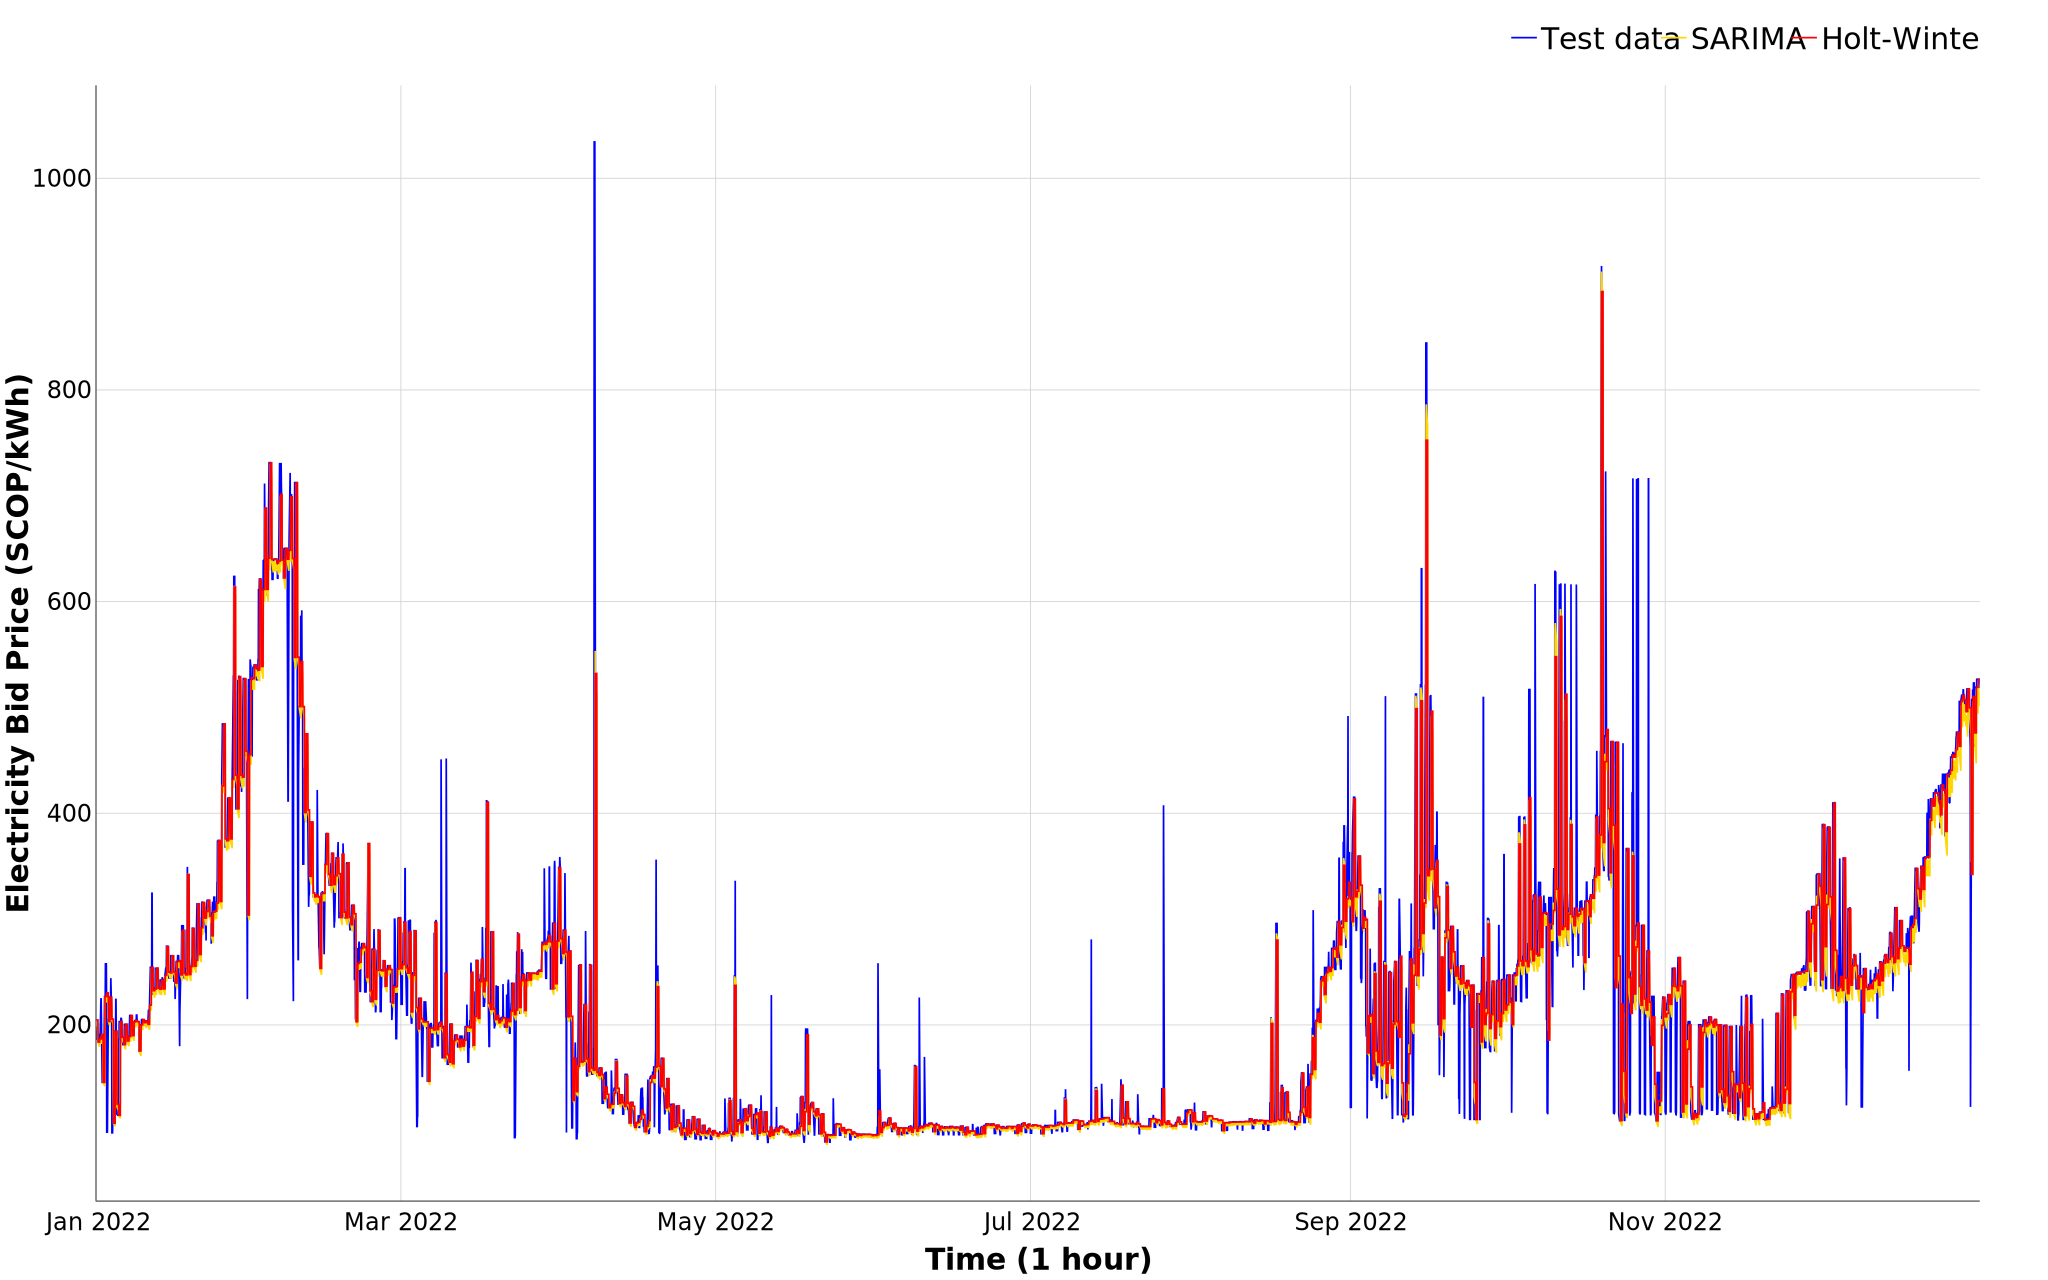

In [9]:
figPBCom = make_subplots(rows=1, cols=1)


figPBCom.append_trace(go.Scatter(y=datosPB_test.Electricity_Bid_Price, x=datosPB_test.index,
                                 mode='lines', line=dict(width=2, color="blue"),
                                 name="Test data", stackgaps='infer zero'), row=1, col=1)
figPBCom.append_trace(go.Scatter(y=pred_SARIMAX, x=datosPB_test.index,
                                 mode='lines', line=dict(width=2, color="gold"),
                                 name="SARIMA", stackgaps='infer zero'), row=1, col=1)
figPBCom.append_trace(go.Scatter(y=pred_HW, x=datosPB_test.index,
                                 mode='lines', line=dict(width=2, color="red"),
                                 name="Holt-Winters", stackgaps='infer zero'), row=1, col=1)

figPBCom.update_layout(title='',
                      paper_bgcolor='rgba(0,0,0,0)',
                      plot_bgcolor='rgba(0,0,0,0)',
                      width=2400,height=1500,
                      yaxis=dict(color="black"),
                      xaxis=dict(color="black"),
                      font=dict(family="Fira Sans, Condensed", color='black'),
                      legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1, font_size=35, font_color='black'),
                      showlegend=True)
#figPBCom.update_xaxes(range=['2022-01-01 00:00:00','2022-01-10 00:00:00'])
figPBCom.update_xaxes(showline=True, linewidth=1, linecolor='black', gridcolor='lightgray', mirror=False, title_text='<b>Time (1 hour)</b>', titlefont_size=35, tickfont_size=28)
figPBCom.update_yaxes(showline=True, linewidth=1, gridcolor='lightgray', linecolor='black', mirror=False, title_text='<b>Electricity Bid Price (SCOP/kWh)</b>', titlefont_size=35, tickfont_size=28)
figPBCom.update_traces(connectgaps=False)
figPBCom.update_annotations(font=dict(size=35))
figPBCom.show("svg")